# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

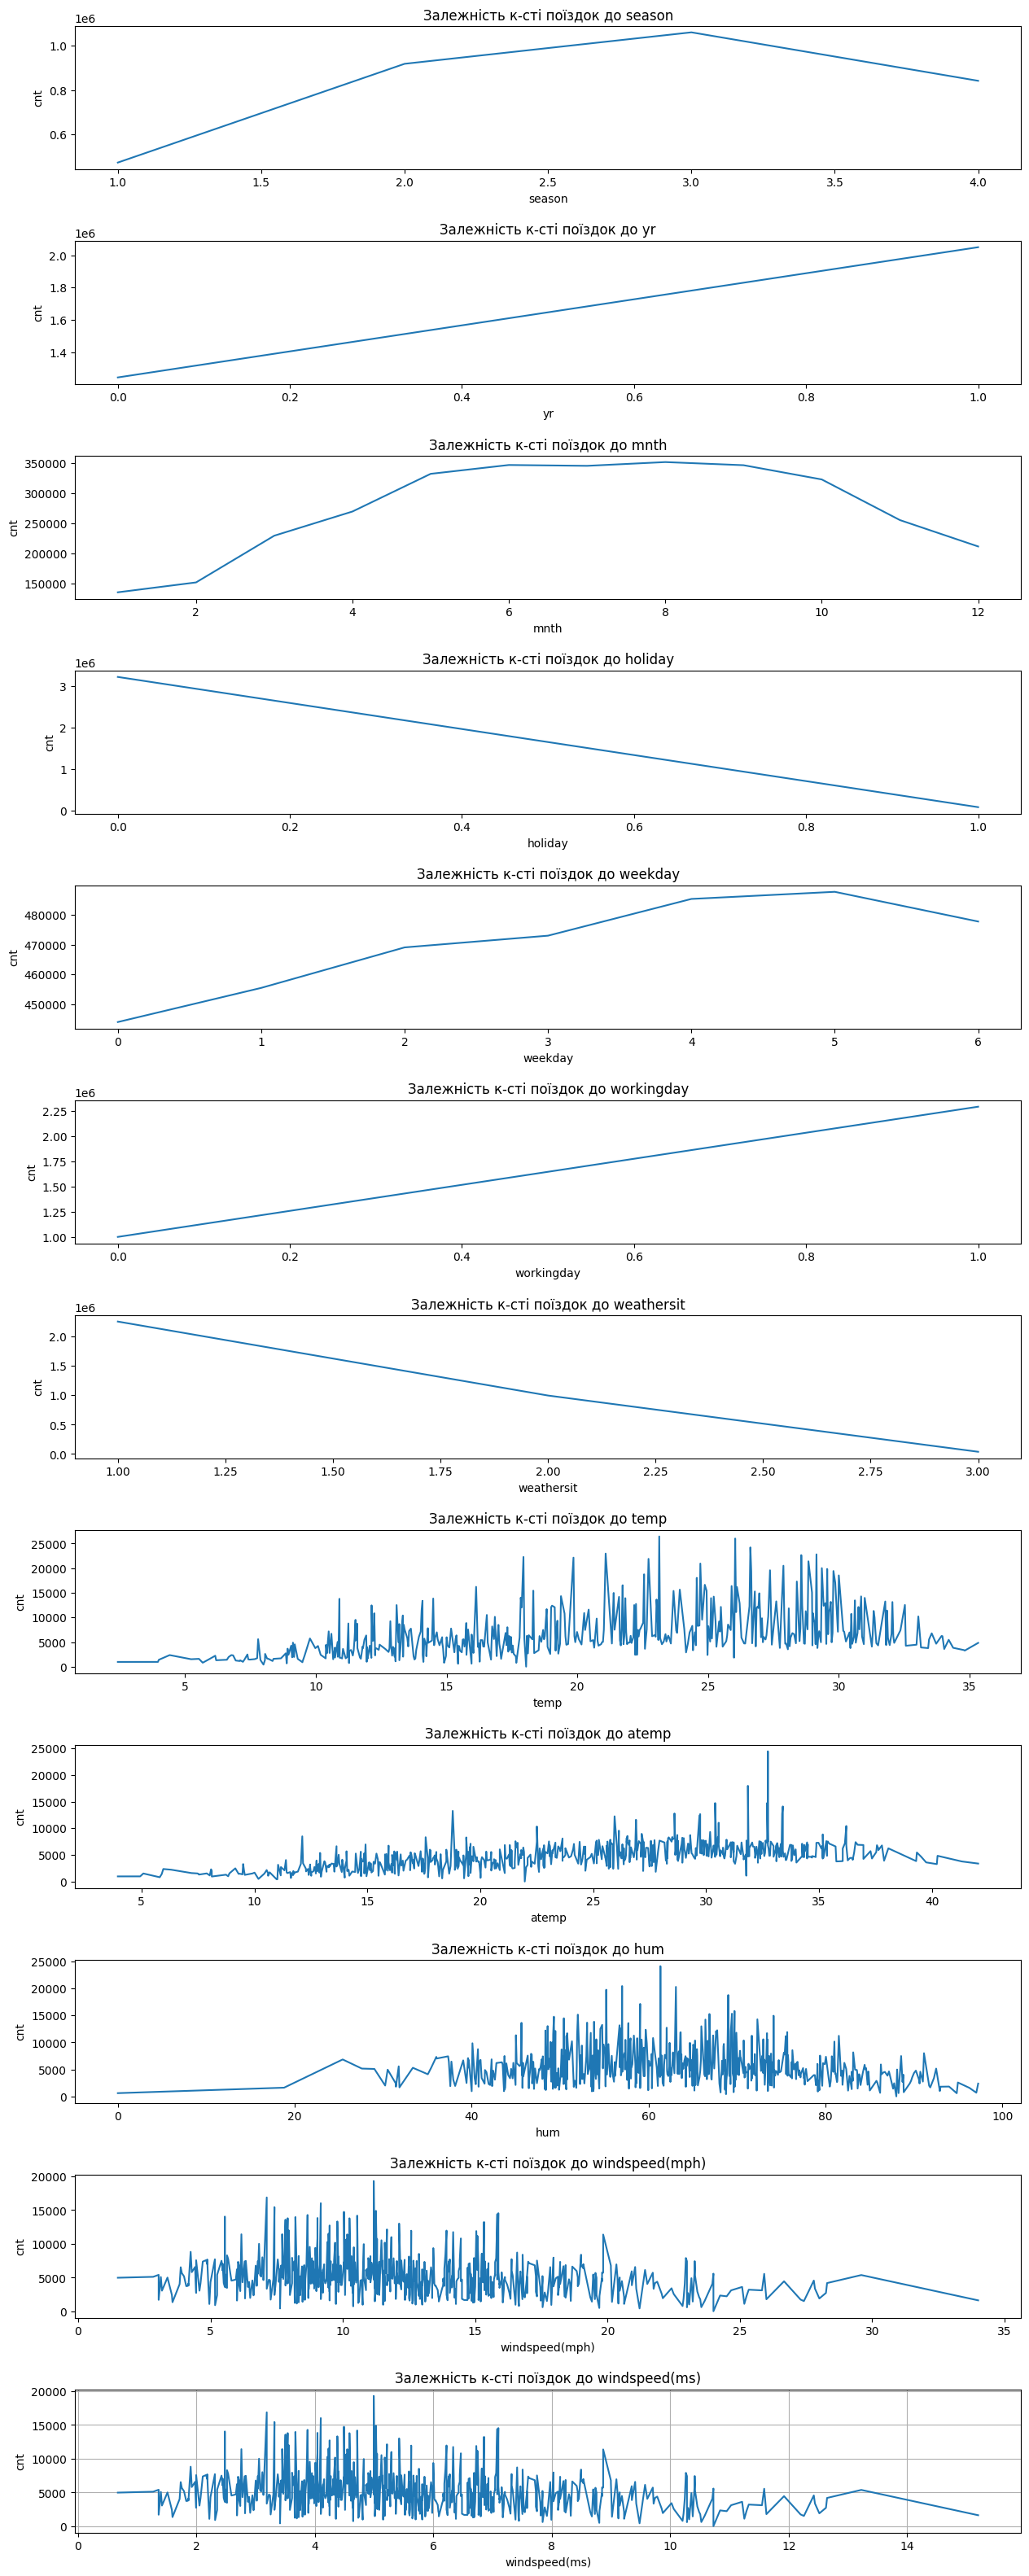

In [3]:
fig = plt.figure(figsize=(15, 40))
fig.subplots_adjust(hspace=0.5)
total_axes = len(df.columns) - 1
subplt = 1
for column in df.columns[:-1]:
    fig.add_subplot(total_axes, 1, subplt)
    group_by_season = df.groupby(column).agg('sum')['cnt']
    group_by_season.plot()
    plt.xlabel(column)
    plt.ylabel('cnt')
    plt.title(f'Залежність к-сті поїздок до {column}')
    subplt+=1

plt.grid()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
- з 1-6 місяця відбувається ріст прокатів з 150000 - 350000, з 6-9 тримається на одному рівні 350000, з 9-12 відбувається спад 350000-200000.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
- yr, holiday,workingday, weathersit

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [4]:
correlations = df.iloc[:, :-1].corrwith(df.iloc[:, -1])
correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [5]:
subset = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
doble_correlations = subset.corr()
doble_correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
means = df.mean()
binary_ratios = df.mean(numeric_only=True)

In [7]:
means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

In [8]:
binary_ratios

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

## Задание 4

Выведите средние признаков

In [9]:
means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [10]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [11]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [12]:
df_shuffled

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509153,23.45270,73.3750,11.666643,5.215308,6606
33,1,0,2,0,4,1,1,7.665237,8.89390,43.7826,18.609384,8.318902,1550
300,4,0,10,0,5,1,2,13.564153,15.94060,58.5833,15.375093,6.873086,3747
456,2,1,4,0,0,0,2,17.459153,20.86435,67.6250,11.541889,5.159539,6041
633,4,1,9,0,2,1,1,22.550000,27.20895,57.0000,15.833507,7.078009,7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0,3,0,0,0,1,15.758268,19.00455,52.7391,18.130468,8.104814,2417
106,2,0,4,0,0,0,1,18.723347,22.28480,47.9583,20.334232,9.089956,3744
270,4,0,9,0,3,1,2,26.035000,28.75790,84.8750,9.958143,4.451561,3907
435,1,1,3,0,0,0,1,14.831299,17.98350,47.6957,14.913329,6.666665,4911


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [13]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [14]:
# Створення об'єкту лінійного регресора
regressor = LinearRegression()

# Навчання моделі на всіх данних
regressor.fit(X, y)

# Вивід ваг моделі
weights = list(zip(df.columns, regressor.coef_))
for feature, weight in weights:
    print(f"Ознака: {feature}, Вага: {weight}")

Ознака: season, Вага: 570.8697178891638
Ознака: yr, Вага: 1021.9655840764684
Ознака: mnth, Вага: -141.30465976132427
Ознака: holiday, Вага: -86.76137844635305
Ознака: weekday, Вага: 137.22671195166865
Ознака: workingday, Вага: 56.39024192963602
Ознака: weathersit, Вага: -330.2291157116696
Ознака: temp, Вага: 367.465102703113
Ознака: atemp, Вага: 585.565259837681
Ознака: hum, Вага: -145.61264700953691
Ознака: windspeed(mph), Вага: 12457860822612.178
Ознака: windspeed(ms), Вага: -12457860822810.635


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [15]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
lasso_weights = list(zip(df.columns, lasso_regressor.coef_))

print("\nВаги моделі Lasso:")
for feature, weight in lasso_weights:
    print(f"Ознака: {feature}, Вага: {weight}")


Ваги моделі Lasso:
Ознака: season, Вага: 560.2416160308865
Ознака: yr, Вага: 1019.4634940657199
Ознака: mnth, Вага: -128.73062703678724
Ознака: holiday, Вага: -86.15278133371073
Ознака: weekday, Вага: 137.3478939049632
Ознака: workingday, Вага: 55.212370641356905
Ознака: weathersit, Вага: -332.3698569623488
Ознака: temp, Вага: 376.36323620969296
Ознака: atemp, Вага: 576.5307935045565
Ознака: hum, Вага: -144.12915500348592
Ознака: windspeed(mph), Вага: -197.1396894024845
Ознака: windspeed(ms), Вага: -2.805117960926034e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [16]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
ridge_weights = list(zip(df.columns, ridge_regressor.coef_))

print("Вага моделі Ridge:")
for feature, weight in ridge_weights:
    print(f"Ознака: {feature}, Вага: {weight}")

Вага моделі Ridge:
Ознака: season, Вага: 563.0645722520183
Ознака: yr, Вага: 1018.9483787875297
Ознака: mnth, Вага: -131.87332028247718
Ознака: holiday, Вага: -86.74609799709235
Ознака: weekday, Вага: 138.0051111787191
Ознака: workingday, Вага: 55.903110375064614
Ознака: weathersit, Вага: -332.3497884990744
Ознака: temp, Вага: 386.457889191934
Ознака: atemp, Вага: 566.3470470600405
Ознака: hum, Вага: -145.0713272986715
Ознака: windspeed(mph), Вага: -99.25944108178645
Ознака: windspeed(ms), Вага: -99.25944115434666


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [17]:
alphas = np.arange(1, 500, 50)

coefs_lasso = list()
coefs_ridge = list()

for alpha in alphas:
    # Обучение регрессора Lasso
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    # Обучение регрессора Ridge
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

In [18]:
coefs_lasso

array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80511796e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29892192e-08],
       [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
        -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
        -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
        -2.75042876e+01, -9.37749037e+01, -2.41658341e-08],
       [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
        -0.00000000e+00, -5.01551472e+01, -2.62785293e-08],
       [ 2.98134448e+02,  8.45652857e+02,  0.0000000

In [19]:
coefs_ridge

array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Проанализируйте динамику весов при увеличении параметра регуляризации:

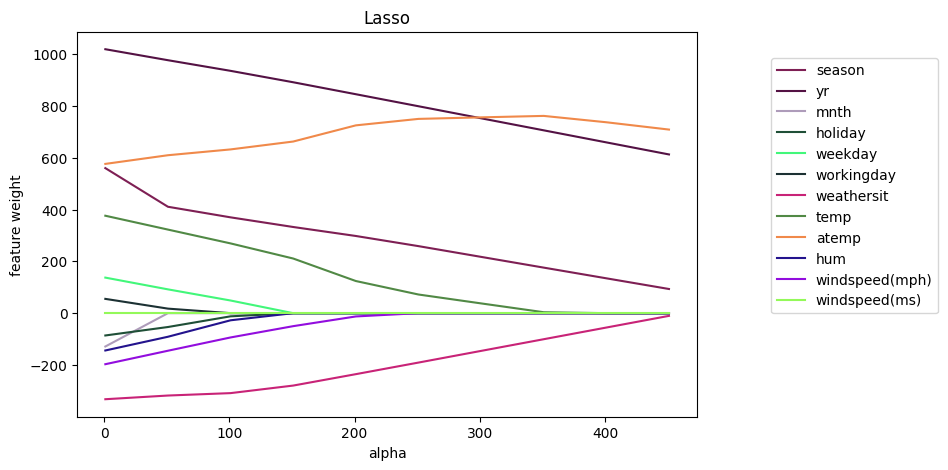

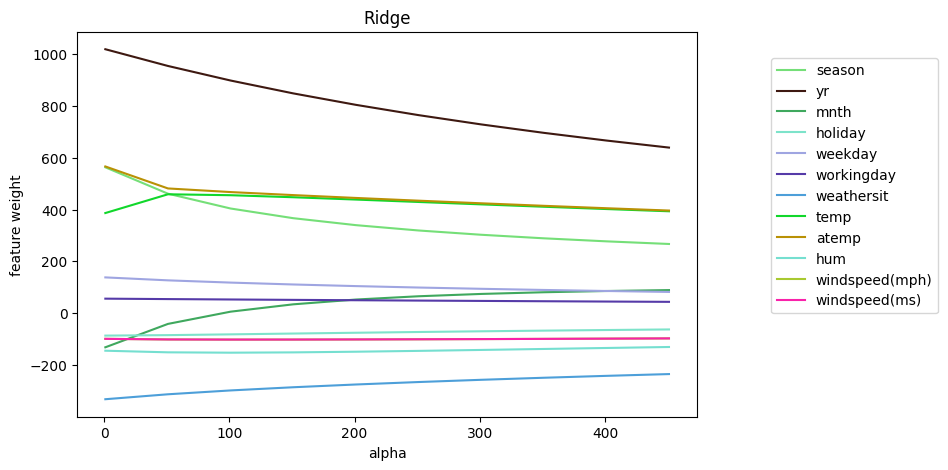

In [20]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha? 
    - Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    - Якщо alpha в Lasso стане дуже великим, всі ваги ознак, крім вільного члена (bias), стануть рівними нулю. Це відбувається через те, що при дуже великих значеннях alpha штраф на абсолютне значення ваг стає настільки сильним, що модель прагне мінімізувати суму ваг ваг і, отже, встановлює максимально можливу кількість ваг рівним нулю.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
    - Так, можна стверджувати, що Lasso виключає одну з ознак windspeed за будь-якого значення alpha > 0, так як Lasso має властивість вибору ознак і може встановити вагу при нерелевантному ознакі рівним нулю. З іншого боку, Ridge не виключає ознак повністю, навіть при дуже маленьких значеннях ваги. Тому можна сказати, що Lasso виключає ознаки ефективніше, ніж Ridge.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    - Для відбору неінформативних ознак найкраще підходить регуляризатор Lasso. Оскільки Lasso може "обнулити" ваги деяких ознак, він дозволяє виключити неінформативні ознаки моделі. У той час як Ridge знижує ваги всіх ознак, але не обнуляє їх повністю, тому він не виключає ознаки так само, як Lasso.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [34]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = data.alphas_
    y = [el.mean() for el in data.mse_path_]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [26]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
print(f' Chosen Aplha: {regressor.alpha_}')
for pair in zip(df_shuffled.columns[:-1], regressor.coef_):
  print(pair)


 Chosen Aplha: 6
('season', 532.0189828413538)
('yr', 1015.0602226430597)
('mnth', -100.03952614356643)
('holiday', -83.29395987529897)
('weekday', 132.50446549095798)
('workingday', 51.55708561407412)
('weathersit', -330.55985673998157)
('temp', 370.67985503003473)
('atemp', 581.3969310654974)
('hum', -140.00740550068872)
('windspeed(mph)', -191.77140847135044)
('windspeed(ms)', -2.6854725954155966e-08)


In [27]:
regressor.score(X, y)

0.800081404381094

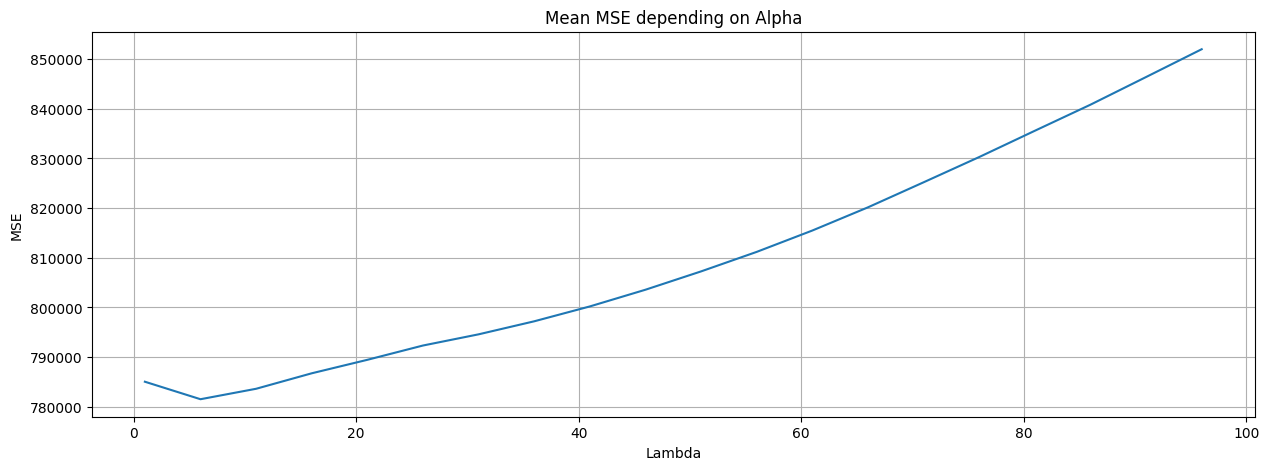

In [36]:
create_plot(regressor, 'Mean MSE depending on Alpha', 'Lambda', 'MSE')

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Значення alpha, що відповідають мінімумам MSE:
Розбиття 1: 6
Розбиття 2: 1
Розбиття 3: 51


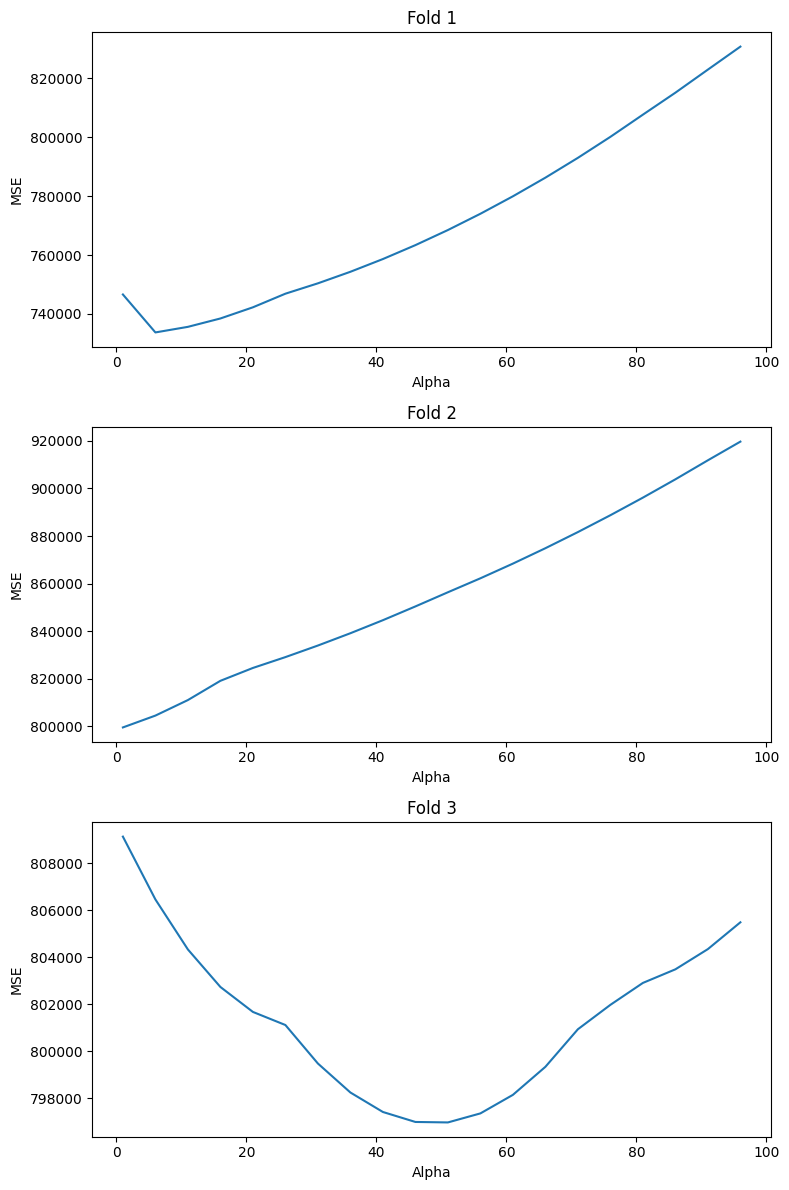

In [37]:
# Індекс мінімуму MSE для кожного стовпця
min_indices = np.argmin(regressor.mse_path_, axis=0)

# Значення alpha, що відповідають мінімумам MSE
min_alphas = regressor.alphas_[min_indices]

# Значення alpha
print("Значення alpha, що відповідають мінімумам MSE:")
for fold, alpha in enumerate(min_alphas):
    print(f"Розбиття {fold+1}: {alpha}")

# Стовпці mse_path_ на окремих графіках
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

for fold, ax in enumerate(axs):
    ax.plot(regressor.alphas_, regressor.mse_path_[:, fold])
    ax.set_xlabel('Alpha')
    ax.set_ylabel('MSE')
    ax.set_title(f'Fold {fold+1}')

plt.tight_layout()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

In [38]:
# Отримайте коефіцієнти та назви ознак
coefficients = regressor.coef_
feature_names = df.columns[:-1]  # Вважаючи, що останній стовпець - цільова змінна "cnt"

# Отримайте індекси 4 признаків з найбільшими (позитивними) коефіцієнтами
top_4_indices = np.argsort(coefficients)[-4:]

# Отримайте назви 4 признаків
top_4_features = feature_names[top_4_indices]

# Виведіть назви 4 признаків з найбільшими (позитивними) коефіцієнтами
print("4 признаки з найбільшими (позитивними) коефіцієнтами:")
for feature in top_4_features:
    print(feature)

4 признаки з найбільшими (позитивними) коефіцієнтами:
temp
season
atemp
yr


__Ответ:__

Так видно зростаючу лінійну залежність. Так логічно стверджувати що чим більше значення цих ознак тим більше людей захоче взяти велосипед.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

In [39]:
# Отримайте коефіцієнти та назви ознак
coefficients = regressor.coef_
feature_names = df.columns[:-1]  # Вважаючи, що останній стовпець - цільова змінна "cnt"

# Отримайте індекси 3 признаків з найбільшими (по модулю) від'ємними коефіцієнтами
top_3_indices = np.argsort(np.abs(coefficients))[:3]

# Отримайте назви 3 признаків
top_3_features = feature_names[top_3_indices]

# Виведіть назви 3 признаків з найбільшими (по модулю) від'ємними коефіцієнтами
print("3 признаки з найбільшими (по модулю) від'ємними коефіцієнтами:")
for feature in top_3_features:
    print(feature)

3 признаки з найбільшими (по модулю) від'ємними коефіцієнтами:
windspeed(ms)
workingday
holiday


__Ответ:__

Так видна спадаюча лінійна залежність крім workingday. Так логічно стверджувати що чим більша величина цих ознак тим менше людей захочуть взяти велосипед, окрім ознаки workingday.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

In [40]:
# Отримайте коефіцієнти та назви ознак
coefficients = regressor.coef_
feature_names = df.columns[:-1]  # Вважаючи, що останній стовпець - цільова змінна "cnt"

# Визначте індекси признаків з коефіцієнтами, близькими до нуля
near_zero_indices = np.where(np.abs(coefficients) < 1e-3)[0]

# Отримайте назви признаків
near_zero_features = feature_names[near_zero_indices]

# Виведіть назви признаків з коефіцієнтами, близькими до нуля
print("Признаки з коефіцієнтами, близькими до нуля:")
for feature in near_zero_features:
    print(feature)


Признаки з коефіцієнтами, близькими до нуля:
windspeed(ms)


__Ответ:__

Ознаки windspeed(ms) модель виключила з моделі тому що вони ідентичні і дублюють ознаки windspeed(mph),просто різні розмірності в данних а по факту це одне і те саме.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.